In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def printStats(y_dev, y_pred):
    # Graph
    plt.scatter(y_dev, y_pred)
    plt.plot(y_pred,y_pred,color='black')
    plt.show()
    
    # Stats
    mae = mean_absolute_error(y_dev, y_pred).round(1)
    rmse = round(math.sqrt(mean_squared_error(y_dev, y_pred)),1)
    r2 = r2_score(y_dev, y_pred).round(2)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [3]:
# Partition training, dev, and test data
seasonAndGame = pd.read_csv('../seasonAndGame.csv')
X = seasonAndGame \
    .loc[:,seasonAndGame.columns.str.contains('-\d+') | seasonAndGame.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonAndGame.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale
ss = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_dev_std = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]
X_train_std_select, X_dev_std_select, X_test_std_select = X_train_std.loc[:,keepCols], X_dev_std.loc[:,keepCols], X_test_std.loc[:,keepCols]

### Linear Regression

#### Base model

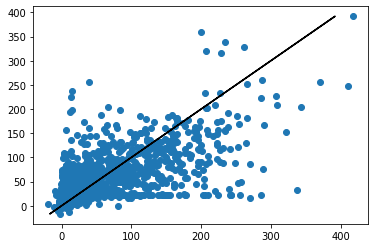

MAE: 31.8
RMSE: 47.6
R^2: 0.44


,rush_yards-3_avgPerGame,yards_gained-3_avgPerGame,rec_yards-3_avgPerGame,yards_gained-3_seasonTotal,rush_yards-3_seasonTotal,rec_yards-3_seasonTotal,rush_yards-2_avgPerGame,rec_yards-2_avgPerGame,yards_gained-2_avgPerGame,pass_attempt-2_avgPerGame,interception-2_avgPerGame,complete_pass-2_avgPerGame,incomplete_pass-2_avgPerGame,complete_pass-3_avgPerGame,pass_attempt-3_avgPerGame,incomplete_pass-3_avgPerGame,interception-3_avgPerGame,pass_touchdown-1_avgPerGame,rush_touchdown-1_avgPerGame,fumble-3_avgPerGame,interception-1_avgPerGame,complete_pass-1_avgPerGame,rush_touchdown-3_avgPerGame,tackled_for_loss-1_avgPerGame,yards_gained-2_seasonTotal,rush_yards-2_seasonTotal,incomplete_pass-1_avgPerGame,rec_yards-2_seasonTotal,touchdown-3_avgPerGame,yards_gained-1_seasonTotal,rec_yards-1_seasonTotal,rush_yards-1_seasonTotal,touchdown-1_avgPerGame,fumble-1_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-1_avgPerGame,no_huddle-1_avgPerGame,interception-2_seasonTotal,pass_touchdown-3_seasonTotal,fumble-2_avgPerGame,qb_dropback-2_avgPerGame,tackled_for_loss-2_avgPerGame,qb_hit-2_avgPerGame,pass_attempt-2_seasonTotal,qb_hit-1_avgPerGame,rush_touchdown-3_seasonTotal,complete_pass-2_seasonTotal,incomplete_pass-2_seasonTotal,complete_pass-3_seasonTotal,rush_touchdown-2_seasonTotal,...,rush_attempt-3_avgPerGame,touchdown-3_seasonTotal,yards_gained-1_avgPerGame,shotgun-3_avgPerGame,complete_pass-1_seasonTotal,pass_attempt-1_seasonTotal,rush_yards-1_avgPerGame,rec_yards-1_avgPerGame,qb_hit-2_seasonTotal,rush_attempt-1_avgPerGame,fanPts-3,touchdown-2_seasonTotal,interception-1_seasonTotal,yards_after_catch-2_avgPerGame,pass_touchdown-2_avgPerGame,no_huddle-1_seasonTotal,fanPts-2,tackled_for_loss-1_seasonTotal,yards_after_catch-1_avgPerGame,tackled_for_loss-2_seasonTotal,qb_dropback-2_seasonTotal,yards_after_catch-3_avgPerGame,fumble-1_seasonTotal,no_huddle-2_seasonTotal,touchdown-1_seasonTotal,qb_hit-3_seasonTotal,rush_attempt-2_seasonTotal,qb_hit-3_avgPerGame,fumble-3_seasonTotal,qb_dropback-3_seasonTotal,rush_attempt-1_seasonTotal,qb_hit-1_seasonTotal,shotgun-2_seasonTotal,no_huddle-3_seasonTotal,tackled_for_loss-3_seasonTotal,fanPts-1,qb_dropback-1_seasonTotal,air_yards-1_avgPerGame,shotgun-1_seasonTotal,yards_after_catch-2_seasonTotal,air_yards-3_avgPerGame,shotgun-3_seasonTotal,yards_after_catch-3_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-2_avgPerGame,rush_attempt-3_seasonTotal,qb_dropback-3_avgPerGame,air_yards-3_seasonTotal,air_yards-1_seasonTotal,air_yards-2_seasonTotal
1,1749.651,-1749.408,1749.395,83.971,-83.852,-83.842,58.315,57.518,-57.415,52.580,-51.922,-47.888,-46.932,40.023,-39.347,37.114,35.424,-33.717,-18.644,-18.543,15.278,15.199,-14.555,14.076,13.068,-13.059,13.050,-12.973,12.882,12.323,-12.252,-12.189,11.857,-11.780,-10.076,-10.067,9.147,8.431,8.412,-8.387,-8.360,8.193,7.972,-7.784,-7.771,7.533,7.478,6.952,-5.573,5.531,...,-1.765,-1.655,1.586,-1.540,1.413,-1.393,-1.258,-1.241,-1.198,-1.157,-1.058,-0.950,0.942,-0.912,-0.755,-0.690,-0.648,-0.642,-0.628,-0.522,0.487,-0.460,-0.434,-0.381,-0.373,0.366,0.347,0.302,-0.238,-0.234,-0.228,0.217,-0.216,-0.159,0.149,-0.136,-0.125,-0.119,-0.091,0.072,0.043,0.042,0.033,0.026,0.018,0.018,-0.013,-0.012,0.009,0.008


In [4]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.LinearRegression()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()

### Ridge Regression

#### Base model

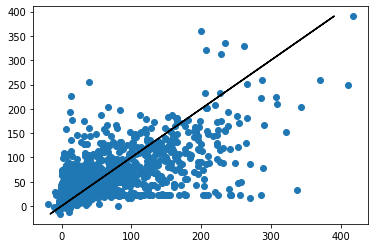

MAE: 31.6
RMSE: 47.2
R^2: 0.45


,pass_touchdown-1_avgPerGame,fumble-3_avgPerGame,tackled_for_loss-1_avgPerGame,complete_pass-3_avgPerGame,pass_attempt-2_avgPerGame,pass_attempt-3_avgPerGame,fumble-1_avgPerGame,interception-2_avgPerGame,incomplete_pass-3_avgPerGame,rush_touchdown-1_avgPerGame,no_huddle-1_avgPerGame,yards_gained-2_seasonTotal,rush_yards-2_seasonTotal,qb_dropback-2_avgPerGame,rec_yards-2_seasonTotal,interception-3_avgPerGame,interception-1_avgPerGame,tackled_for_loss-2_avgPerGame,fumble-2_avgPerGame,pass_touchdown-3_seasonTotal,qb_hit-1_avgPerGame,qb_hit-2_avgPerGame,complete_pass-2_avgPerGame,complete_pass-1_avgPerGame,yards_gained-1_seasonTotal,rec_yards-1_seasonTotal,rush_touchdown-3_avgPerGame,rush_yards-1_seasonTotal,rush_touchdown-3_seasonTotal,incomplete_pass-2_avgPerGame,touchdown-3_avgPerGame,rec_yards-3_seasonTotal,rush_yards-3_seasonTotal,qb_dropback-1_avgPerGame,yards_gained-3_seasonTotal,interception-2_seasonTotal,rush_touchdown-2_seasonTotal,incomplete_pass-1_avgPerGame,no_huddle-2_avgPerGame,rush_attempt-2_avgPerGame,pass_attempt-2_seasonTotal,pass_touchdown-2_seasonTotal,complete_pass-2_seasonTotal,incomplete_pass-2_seasonTotal,shotgun-2_avgPerGame,complete_pass-3_seasonTotal,pass_attempt-3_seasonTotal,pass_touchdown-3_avgPerGame,touchdown-1_avgPerGame,incomplete_pass-3_seasonTotal,...,yards_gained-3_avgPerGame,fanPts-3,qb_hit-2_seasonTotal,rush_attempt-1_avgPerGame,qb_hit-3_avgPerGame,rush_touchdown-2_avgPerGame,yards_gained-1_avgPerGame,yards_after_catch-2_avgPerGame,touchdown-2_seasonTotal,rush_yards-1_avgPerGame,no_huddle-1_seasonTotal,rec_yards-1_avgPerGame,yards_after_catch-1_avgPerGame,fanPts-2,tackled_for_loss-1_seasonTotal,fumble-3_seasonTotal,yards_gained-2_avgPerGame,rec_yards-2_avgPerGame,tackled_for_loss-2_seasonTotal,qb_dropback-2_seasonTotal,yards_after_catch-3_avgPerGame,no_huddle-2_seasonTotal,pass_touchdown-2_avgPerGame,rush_yards-2_avgPerGame,rush_attempt-2_seasonTotal,touchdown-3_seasonTotal,fumble-1_seasonTotal,qb_hit-3_seasonTotal,qb_dropback-3_seasonTotal,rush_attempt-1_seasonTotal,touchdown-1_seasonTotal,shotgun-2_seasonTotal,qb_hit-1_seasonTotal,tackled_for_loss-3_seasonTotal,no_huddle-3_seasonTotal,air_yards-1_avgPerGame,qb_dropback-1_seasonTotal,shotgun-1_seasonTotal,qb_dropback-3_avgPerGame,yards_after_catch-2_seasonTotal,shotgun-3_seasonTotal,air_yards-3_avgPerGame,fanPts-1,air_yards-2_avgPerGame,yards_after_catch-3_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-3_seasonTotal,air_yards-1_seasonTotal,rush_attempt-3_seasonTotal,air_yards-2_seasonTotal
1,-23.660,-17.467,13.798,12.945,12.584,-12.311,-11.213,-10.326,10.195,-9.372,9.061,8.369,-8.363,-8.357,-8.272,8.153,8.144,8.072,-7.877,7.816,-7.688,7.615,-7.526,7.296,7.095,-7.034,-6.989,-6.970,6.907,-6.471,5.812,5.621,5.614,-5.511,-5.480,5.351,5.343,5.095,4.986,-4.857,-4.793,4.611,4.479,3.937,3.762,-3.500,3.392,-3.289,3.088,-3.056,...,-1.336,-1.183,-1.170,-1.102,1.091,-1.052,1.002,-0.877,-0.864,-0.689,-0.686,-0.653,-0.643,-0.627,-0.621,-0.567,0.562,-0.528,-0.517,0.476,-0.453,-0.399,0.395,0.354,0.352,-0.295,-0.283,0.283,-0.232,-0.232,-0.219,-0.215,0.196,0.183,-0.142,-0.123,-0.113,-0.094,-0.093,0.069,0.052,0.039,-0.036,0.033,0.033,0.028,-0.011,0.010,0.009,0.007


In [5]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.Ridge()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished


Best parameters set found on development set:
{'alpha': 0.1, 'normalize': True}


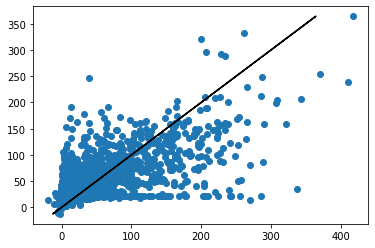

MAE: 31.4
RMSE: 46.9
R^2: 0.46


,fumble-3_avgPerGame,fumble-2_avgPerGame,fumble-1_avgPerGame,qb_hit-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_touchdown-3_avgPerGame,touchdown-3_avgPerGame,touchdown-1_avgPerGame,tackled_for_loss-1_avgPerGame,touchdown-2_avgPerGame,rush_touchdown-3_avgPerGame,interception-2_avgPerGame,no_huddle-1_avgPerGame,interception-1_avgPerGame,qb_hit-2_avgPerGame,no_huddle-2_avgPerGame,pass_touchdown-2_avgPerGame,incomplete_pass-2_avgPerGame,tackled_for_loss-3_avgPerGame,rush_touchdown-2_avgPerGame,qb_hit-3_avgPerGame,pass_touchdown-1_seasonTotal,qb_dropback-2_avgPerGame,rush_touchdown-1_seasonTotal,tackled_for_loss-2_avgPerGame,qb_dropback-1_avgPerGame,touchdown-1_seasonTotal,qb_dropback-3_avgPerGame,shotgun-3_avgPerGame,complete_pass-3_avgPerGame,rush_attempt-3_avgPerGame,fumble-1_seasonTotal,fumble-2_seasonTotal,interception-2_seasonTotal,fumble-3_seasonTotal,pass_touchdown-3_seasonTotal,rush_attempt-2_avgPerGame,pass_touchdown-2_seasonTotal,shotgun-2_avgPerGame,qb_hit-2_seasonTotal,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,no_huddle-3_avgPerGame,incomplete_pass-1_avgPerGame,incomplete_pass-3_avgPerGame,rush_touchdown-2_seasonTotal,pass_attempt-3_avgPerGame,interception-3_avgPerGame,no_huddle-1_seasonTotal,rush_yards-1_avgPerGame,...,yards_after_catch-3_avgPerGame,yards_after_catch-2_avgPerGame,tackled_for_loss-1_seasonTotal,complete_pass-1_seasonTotal,rec_yards-2_avgPerGame,incomplete_pass-2_seasonTotal,pass_attempt-1_avgPerGame,interception-1_seasonTotal,yards_gained-2_avgPerGame,pass_attempt-1_seasonTotal,complete_pass-2_seasonTotal,rec_yards-3_avgPerGame,rush_yards-2_avgPerGame,incomplete_pass-3_seasonTotal,air_yards-3_avgPerGame,fanPts-2,air_yards-2_avgPerGame,yards_gained-3_avgPerGame,qb_dropback-3_seasonTotal,no_huddle-3_seasonTotal,rush_yards-1_seasonTotal,air_yards-1_avgPerGame,fanPts-3,qb_dropback-1_seasonTotal,yards_gained-1_seasonTotal,rec_yards-1_seasonTotal,shotgun-1_seasonTotal,yards_after_catch-2_seasonTotal,rush_yards-3_avgPerGame,shotgun-3_seasonTotal,touchdown-2_seasonTotal,qb_dropback-2_seasonTotal,complete_pass-3_seasonTotal,rec_yards-2_seasonTotal,rush_attempt-1_seasonTotal,pass_attempt-2_seasonTotal,yards_after_catch-3_seasonTotal,yards_after_catch-1_seasonTotal,yards_gained-2_seasonTotal,rush_yards-3_seasonTotal,air_yards-1_seasonTotal,rec_yards-3_seasonTotal,yards_gained-3_seasonTotal,rush_attempt-3_seasonTotal,air_yards-2_seasonTotal,shotgun-2_seasonTotal,rush_yards-2_seasonTotal,air_yards-3_seasonTotal,pass_attempt-3_seasonTotal,rush_attempt-2_seasonTotal
1,-15.014,-14.125,-12.731,-7.726,-7.700,5.157,-4.939,-4.447,4.034,-3.459,-2.802,-2.769,2.750,-2.291,-2.263,2.043,1.857,-1.436,-1.371,1.187,-1.181,1.037,-0.960,0.880,0.797,-0.796,0.789,-0.784,-0.714,-0.654,-0.564,-0.542,-0.535,0.484,0.475,0.424,-0.420,0.408,0.408,-0.368,-0.362,-0.337,0.309,0.303,-0.301,0.296,-0.293,0.272,-0.237,0.210,...,-0.085,-0.080,0.073,0.066,0.065,-0.057,0.054,-0.051,0.048,0.047,0.043,0.043,0.033,0.032,-0.031,0.030,0.030,0.028,-0.020,-0.020,0.019,-0.018,0.017,0.017,0.015,0.014,0.014,0.014,0.013,-0.013,0.013,-0.012,-0.011,0.009,0.009,0.008,0.008,0.007,0.006,0.005,0.005,0.004,0.004,-0.004,0.003,0.002,0.002,-0.002,0.001,-0.001


In [6]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Ridge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Ridge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

### Lasso Regression

#### Base model

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10376.528338305652, tolerance: 3037.9150681688084
  positive)


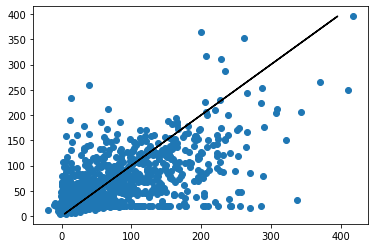

MAE: 31.6
RMSE: 47.2
R^2: 0.45


,qb_dropback-1_seasonTotal,fumble-2_seasonTotal,incomplete_pass-1_seasonTotal,rush_attempt-1_seasonTotal,pass_attempt-1_seasonTotal,qb_dropback-2_seasonTotal,tackled_for_loss-1_seasonTotal,yards_gained-3_avgPerGame,fanPts-1,qb_dropback-3_seasonTotal,incomplete_pass-2_seasonTotal,yards_gained-1_avgPerGame,qb_hit-2_seasonTotal,rush_attempt-3_seasonTotal,air_yards-1_avgPerGame,fumble-1_seasonTotal,rec_yards-2_avgPerGame,incomplete_pass-3_seasonTotal,rush_yards-1_avgPerGame,yards_gained-2_avgPerGame,no_huddle-1_seasonTotal,yards_gained-1_seasonTotal,complete_pass-2_seasonTotal,rush_yards-3_avgPerGame,complete_pass-1_seasonTotal,shotgun-3_seasonTotal,yards_gained-3_seasonTotal,rush_yards-1_seasonTotal,fanPts-2,yards_gained-2_seasonTotal,shotgun-1_seasonTotal,shotgun-2_seasonTotal,rec_yards-2_seasonTotal,rush_yards-2_seasonTotal,rec_yards-1_seasonTotal,yards_after_catch-1_seasonTotal,rush_yards-3_seasonTotal,air_yards-1_seasonTotal,air_yards-3_seasonTotal,yards_after_catch-2_seasonTotal,air_yards-2_seasonTotal,yards_after_catch-3_seasonTotal,air_yards-2_avgPerGame,rush_attempt-2_seasonTotal,rush_touchdown-2_seasonTotal,interception-3_avgPerGame,touchdown-2_avgPerGame,pass_touchdown-2_seasonTotal,tackled_for_loss-2_seasonTotal,touchdown-2_seasonTotal,...,qb_hit-3_avgPerGame,qb_dropback-3_avgPerGame,fumble-3_seasonTotal,pass_attempt-3_avgPerGame,interception-2_seasonTotal,complete_pass-3_seasonTotal,pass_attempt-3_seasonTotal,incomplete_pass-3_avgPerGame,incomplete_pass-2_avgPerGame,tackled_for_loss-1_avgPerGame,touchdown-1_avgPerGame,rush_yards-2_avgPerGame,yards_after_catch-1_avgPerGame,yards_after_catch-2_avgPerGame,rec_yards-1_avgPerGame,complete_pass-2_avgPerGame,fumble-2_avgPerGame,interception-2_avgPerGame,rush_touchdown-1_avgPerGame,no_huddle-2_avgPerGame,pass_attempt-2_avgPerGame,pass_touchdown-2_avgPerGame,qb_dropback-2_avgPerGame,qb_hit-2_avgPerGame,rush_attempt-2_avgPerGame,rush_touchdown-2_avgPerGame,shotgun-2_avgPerGame,shotgun-1_avgPerGame,rush_attempt-1_avgPerGame,interception-3_seasonTotal,touchdown-3_seasonTotal,no_huddle-3_seasonTotal,tackled_for_loss-2_avgPerGame,pass_touchdown-3_seasonTotal,fumble-3_avgPerGame,qb_hit-3_seasonTotal,complete_pass-3_avgPerGame,rush_touchdown-3_seasonTotal,tackled_for_loss-3_seasonTotal,rec_yards-3_avgPerGame,qb_hit-1_avgPerGame,complete_pass-1_avgPerGame,fumble-1_avgPerGame,incomplete_pass-1_avgPerGame,interception-1_avgPerGame,no_huddle-1_avgPerGame,pass_attempt-1_avgPerGame,pass_touchdown-1_avgPerGame,qb_dropback-1_avgPerGame,rec_yards-3_seasonTotal
1,-0.479,-0.426,0.372,-0.282,0.257,-0.238,0.225,-0.225,0.211,-0.199,-0.179,0.164,-0.159,-0.124,-0.120,-0.114,-0.104,0.091,0.074,-0.073,-0.071,0.066,0.062,-0.059,0.045,-0.038,0.038,0.038,0.035,0.033,0.032,0.020,0.018,-0.017,-0.014,-0.013,0.012,0.009,-0.007,0.006,0.005,0.005,0.004,-0.002,0.000,0.000,-0.000,0.000,0.000,-0.000,...,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000


In [7]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.Lasso()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.5s finished


Best parameters set found on development set:
{'alpha': 0.01, 'normalize': True}


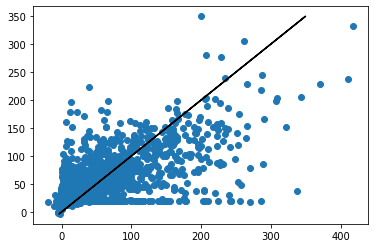

MAE: 31.7
RMSE: 47.2
R^2: 0.45


,fumble-2_avgPerGame,fumble-3_avgPerGame,fumble-1_avgPerGame,tackled_for_loss-1_avgPerGame,fanPts-1,shotgun-3_avgPerGame,yards_gained-1_avgPerGame,fanPts-2,yards_gained-1_seasonTotal,yards_gained-2_seasonTotal,incomplete_pass-1_seasonTotal,rec_yards-2_seasonTotal,tackled_for_loss-2_seasonTotal,touchdown-2_seasonTotal,rush_yards-2_seasonTotal,yards_after_catch-2_seasonTotal,shotgun-2_seasonTotal,air_yards-2_seasonTotal,complete_pass-3_seasonTotal,fanPts-3,rush_attempt-2_seasonTotal,fumble-3_seasonTotal,incomplete_pass-3_seasonTotal,interception-3_seasonTotal,no_huddle-3_seasonTotal,pass_attempt-3_seasonTotal,pass_touchdown-3_seasonTotal,qb_dropback-3_seasonTotal,qb_hit-3_seasonTotal,rush_attempt-3_seasonTotal,rush_touchdown-3_seasonTotal,shotgun-3_seasonTotal,rush_touchdown-2_seasonTotal,pass_touchdown-2_seasonTotal,qb_hit-2_seasonTotal,tackled_for_loss-1_seasonTotal,complete_pass-1_seasonTotal,fumble-1_seasonTotal,interception-1_seasonTotal,no_huddle-1_seasonTotal,pass_attempt-1_seasonTotal,pass_touchdown-1_seasonTotal,qb_dropback-1_seasonTotal,qb_hit-1_seasonTotal,rush_attempt-1_seasonTotal,rush_touchdown-1_seasonTotal,shotgun-1_seasonTotal,touchdown-1_seasonTotal,qb_dropback-2_seasonTotal,air_yards-1_seasonTotal,...,touchdown-2_avgPerGame,air_yards-2_avgPerGame,yards_after_catch-2_avgPerGame,yards_gained-2_avgPerGame,rec_yards-2_avgPerGame,rush_yards-2_avgPerGame,complete_pass-3_avgPerGame,incomplete_pass-3_avgPerGame,no_huddle-3_avgPerGame,qb_hit-2_avgPerGame,pass_attempt-3_avgPerGame,pass_touchdown-3_avgPerGame,qb_dropback-3_avgPerGame,qb_hit-3_avgPerGame,rush_attempt-3_avgPerGame,rush_touchdown-3_avgPerGame,tackled_for_loss-3_avgPerGame,touchdown-3_avgPerGame,air_yards-3_avgPerGame,yards_after_catch-3_avgPerGame,yards_gained-3_avgPerGame,rush_attempt-2_avgPerGame,qb_dropback-2_avgPerGame,yards_after_catch-3_seasonTotal,rush_attempt-1_avgPerGame,yards_gained-3_seasonTotal,rec_yards-3_avgPerGame,rush_yards-3_seasonTotal,complete_pass-1_avgPerGame,incomplete_pass-1_avgPerGame,interception-1_avgPerGame,no_huddle-1_avgPerGame,pass_attempt-1_avgPerGame,pass_touchdown-1_avgPerGame,qb_dropback-1_avgPerGame,qb_hit-1_avgPerGame,rush_touchdown-1_avgPerGame,pass_touchdown-2_avgPerGame,shotgun-1_avgPerGame,touchdown-1_avgPerGame,air_yards-1_avgPerGame,yards_after_catch-1_avgPerGame,rec_yards-1_avgPerGame,rush_yards-1_avgPerGame,complete_pass-2_avgPerGame,incomplete_pass-2_avgPerGame,interception-2_avgPerGame,no_huddle-2_avgPerGame,pass_attempt-2_avgPerGame,rec_yards-3_seasonTotal
1,-14.372,-11.297,-8.172,2.590,0.229,-0.110,0.066,0.048,0.046,0.008,0.007,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000


In [8]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Lasso(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.5s finished


Best parameters set found on development set:
{'alpha': 0.1, 'normalize': False}


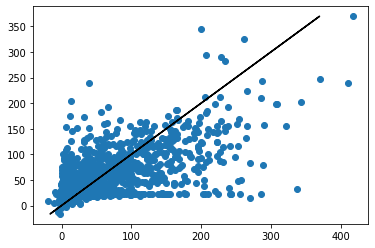

MAE: 31.4
RMSE: 46.8
R^2: 0.46


,fanPts-1,yards_gained-1_seasonTotal,yards_gained-1_avgPerGame,rush_attempt-1_seasonTotal,rec_yards-2_seasonTotal,rush_yards-1_seasonTotal,qb_dropback-2_avgPerGame,yards_gained-3_seasonTotal,yards_gained-2_seasonTotal,qb_dropback-1_avgPerGame,no_huddle-1_seasonTotal,incomplete_pass-1_seasonTotal,qb_dropback-3_avgPerGame,no_huddle-1_avgPerGame,tackled_for_loss-1_avgPerGame,rush_attempt-3_avgPerGame,incomplete_pass-2_seasonTotal,fumble-2_avgPerGame,rush_attempt-1_avgPerGame,pass_touchdown-1_avgPerGame,yards_after_catch-2_seasonTotal,fumble-1_avgPerGame,fumble-3_avgPerGame,air_yards-1_seasonTotal,shotgun-3_avgPerGame,qb_hit-2_seasonTotal,rush_yards-3_seasonTotal,yards_after_catch-1_avgPerGame,air_yards-2_seasonTotal,qb_hit-1_avgPerGame,no_huddle-2_seasonTotal,no_huddle-2_avgPerGame,pass_touchdown-3_avgPerGame,shotgun-2_avgPerGame,yards_gained-2_avgPerGame,pass_touchdown-1_seasonTotal,touchdown-1_avgPerGame,rush_touchdown-2_seasonTotal,shotgun-1_avgPerGame,touchdown-3_avgPerGame,air_yards-3_seasonTotal,interception-1_seasonTotal,fumble-3_seasonTotal,rush_attempt-2_avgPerGame,pass_touchdown-3_seasonTotal,fumble-1_seasonTotal,tackled_for_loss-2_seasonTotal,air_yards-3_avgPerGame,pass_touchdown-2_seasonTotal,fumble-2_seasonTotal,...,shotgun-1_seasonTotal,pass_attempt-2_seasonTotal,tackled_for_loss-1_seasonTotal,touchdown-1_seasonTotal,yards_after_catch-1_seasonTotal,rec_yards-1_seasonTotal,complete_pass-3_seasonTotal,fanPts-2,rush_yards-3_avgPerGame,incomplete_pass-3_seasonTotal,incomplete_pass-2_avgPerGame,pass_attempt-2_avgPerGame,qb_hit-2_avgPerGame,rush_touchdown-2_avgPerGame,tackled_for_loss-2_avgPerGame,touchdown-2_avgPerGame,yards_after_catch-2_avgPerGame,rec_yards-2_avgPerGame,rush_yards-2_avgPerGame,complete_pass-3_avgPerGame,incomplete_pass-3_avgPerGame,interception-3_avgPerGame,no_huddle-3_avgPerGame,pass_attempt-3_avgPerGame,qb_hit-3_avgPerGame,rush_touchdown-3_avgPerGame,tackled_for_loss-3_avgPerGame,yards_after_catch-3_avgPerGame,interception-2_avgPerGame,complete_pass-2_avgPerGame,interception-3_seasonTotal,rush_yards-1_avgPerGame,no_huddle-3_seasonTotal,pass_attempt-3_seasonTotal,qb_dropback-3_seasonTotal,qb_hit-3_seasonTotal,rush_attempt-3_seasonTotal,rush_touchdown-3_seasonTotal,shotgun-3_seasonTotal,tackled_for_loss-3_seasonTotal,touchdown-3_seasonTotal,yards_after_catch-3_seasonTotal,rec_yards-3_avgPerGame,complete_pass-1_avgPerGame,interception-1_avgPerGame,pass_attempt-1_avgPerGame,rush_touchdown-1_avgPerGame,air_yards-1_avgPerGame,rec_yards-1_avgPerGame,rec_yards-3_seasonTotal
1,17.062,14.600,8.758,-8.135,7.120,7.098,-5.306,4.622,4.410,-4.239,-3.718,3.620,-3.333,3.288,3.034,-2.817,-2.394,-1.860,-1.655,-1.515,1.504,-1.470,-1.462,1.453,-1.347,-1.272,1.272,-1.246,1.233,-1.177,-1.154,1.087,0.990,0.915,0.869,0.847,-0.790,0.738,0.736,-0.732,-0.680,-0.614,0.506,-0.405,0.386,-0.372,0.372,-0.336,0.315,-0.274,...,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000


In [9]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Lasso(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized, hand-selected features

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2514931.4810776645, tolerance: 3037.9150681688084
  positive)


Best parameters set found on development set:
{'alpha': 0.01, 'normalize': False}


C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2514931.4810776645, tolerance: 3037.9150681688084
  positive)


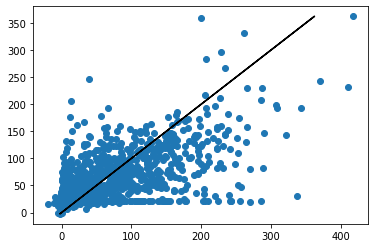

MAE: 31.5
RMSE: 47.2
R^2: 0.45


,fanPts-1,fanPts-2,yards_gained-2_seasonTotal,fanPts-3,touchdown-2_seasonTotal,touchdown-1_seasonTotal,rush_attempt-1_seasonTotal,complete_pass-1_seasonTotal,touchdown-3_seasonTotal,rush_attempt-1_avgPerGame,rush_attempt-3_avgPerGame,yards_gained-3_seasonTotal,complete_pass-3_avgPerGame,complete_pass-2_avgPerGame,touchdown-1_avgPerGame,complete_pass-3_seasonTotal,complete_pass-1_avgPerGame,rush_attempt-2_avgPerGame,yards_gained-1_seasonTotal,rush_attempt-3_seasonTotal,complete_pass-2_seasonTotal,yards_gained-1_avgPerGame,yards_gained-2_avgPerGame,touchdown-3_avgPerGame,touchdown-2_avgPerGame,rush_attempt-2_seasonTotal,yards_gained-3_avgPerGame
1,59.706,44.636,-22.448,17.468,-13.815,-12.511,-8.457,-8.261,-6.275,5.748,-5.120,-4.303,-3.634,-3.425,-3.089,-2.929,2.412,-2.395,-2.193,1.940,1.527,1.281,0.737,-0.485,-0.212,0.000,0.000


In [10]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.Lasso(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

### Elastic Net Regression

#### Base model

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43821.63215375319, tolerance: 3037.9150681688084
  positive)


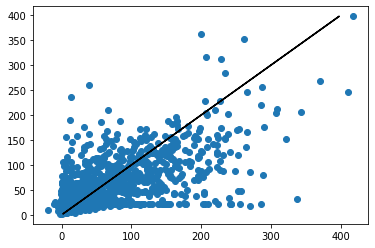

MAE: 31.6
RMSE: 47.2
R^2: 0.45


,fumble-2_seasonTotal,qb_dropback-1_seasonTotal,incomplete_pass-1_seasonTotal,fumble-1_seasonTotal,qb_hit-2_seasonTotal,rush_attempt-1_seasonTotal,tackled_for_loss-1_seasonTotal,incomplete_pass-2_seasonTotal,qb_dropback-2_seasonTotal,fanPts-1,qb_dropback-3_seasonTotal,rec_yards-2_avgPerGame,yards_gained-1_avgPerGame,pass_attempt-1_seasonTotal,yards_gained-3_avgPerGame,yards_after_catch-3_avgPerGame,rush_attempt-2_avgPerGame,qb_hit-1_seasonTotal,incomplete_pass-3_seasonTotal,complete_pass-1_seasonTotal,air_yards-1_avgPerGame,rush_attempt-3_seasonTotal,rush_attempt-3_avgPerGame,yards_after_catch-1_avgPerGame,rush_yards-3_avgPerGame,complete_pass-2_seasonTotal,no_huddle-1_seasonTotal,rush_yards-1_avgPerGame,yards_gained-1_seasonTotal,pass_touchdown-3_seasonTotal,air_yards-2_avgPerGame,complete_pass-3_seasonTotal,shotgun-3_seasonTotal,yards_after_catch-2_avgPerGame,yards_gained-3_seasonTotal,shotgun-1_seasonTotal,fanPts-2,rush_yards-1_seasonTotal,yards_gained-2_seasonTotal,shotgun-2_seasonTotal,yards_gained-2_avgPerGame,rush_yards-2_seasonTotal,rec_yards-1_seasonTotal,fanPts-3,yards_after_catch-3_seasonTotal,rec_yards-2_seasonTotal,rush_yards-3_seasonTotal,air_yards-1_seasonTotal,yards_after_catch-2_seasonTotal,air_yards-3_seasonTotal,...,incomplete_pass-3_avgPerGame,interception-3_avgPerGame,qb_hit-3_avgPerGame,rush_touchdown-3_avgPerGame,pass_touchdown-1_seasonTotal,pass_touchdown-2_seasonTotal,pass_attempt-3_avgPerGame,pass_attempt-2_seasonTotal,no_huddle-2_seasonTotal,touchdown-1_seasonTotal,tackled_for_loss-2_avgPerGame,fumble-3_seasonTotal,incomplete_pass-2_avgPerGame,rush_touchdown-1_avgPerGame,shotgun-1_avgPerGame,tackled_for_loss-1_avgPerGame,touchdown-1_avgPerGame,rec_yards-1_avgPerGame,complete_pass-2_avgPerGame,fumble-2_avgPerGame,interception-2_avgPerGame,qb_hit-1_avgPerGame,no_huddle-2_avgPerGame,pass_attempt-2_avgPerGame,pass_touchdown-2_avgPerGame,qb_dropback-2_avgPerGame,qb_hit-2_avgPerGame,touchdown-2_avgPerGame,rush_touchdown-2_avgPerGame,rush_attempt-1_avgPerGame,qb_dropback-1_avgPerGame,fumble-3_avgPerGame,tackled_for_loss-3_seasonTotal,interception-3_seasonTotal,shotgun-2_avgPerGame,pass_attempt-3_seasonTotal,complete_pass-3_avgPerGame,qb_hit-3_seasonTotal,rush_yards-2_avgPerGame,rush_touchdown-3_seasonTotal,touchdown-3_seasonTotal,pass_touchdown-1_avgPerGame,rec_yards-3_avgPerGame,complete_pass-1_avgPerGame,fumble-1_avgPerGame,incomplete_pass-1_avgPerGame,interception-1_avgPerGame,no_huddle-1_avgPerGame,pass_attempt-1_avgPerGame,no_huddle-3_seasonTotal
1,-0.571,-0.481,0.467,-0.377,-0.307,-0.290,0.287,-0.233,-0.226,0.209,-0.203,-0.201,0.192,0.180,-0.178,-0.167,-0.158,-0.157,0.144,0.139,-0.129,-0.116,-0.113,-0.104,-0.096,0.095,-0.088,0.069,0.067,0.064,0.060,-0.046,-0.044,-0.041,0.040,0.038,0.038,0.037,0.035,0.028,-0.023,-0.021,-0.018,-0.018,0.017,0.016,0.012,0.010,0.009,-0.008,...,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000


In [11]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.ElasticNet()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.3s finished


Best parameters set found on development set:
{'alpha': 10, 'normalize': False}


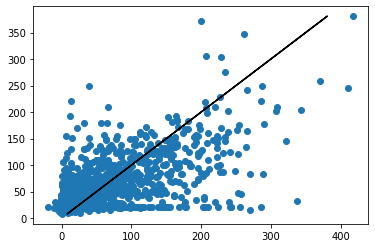

MAE: 31.5
RMSE: 47.2
R^2: 0.45


,qb_dropback-2_seasonTotal,yards_gained-3_avgPerGame,fanPts-1,rush_attempt-1_seasonTotal,qb_dropback-3_seasonTotal,qb_dropback-1_seasonTotal,yards_gained-2_avgPerGame,yards_gained-1_avgPerGame,rush_attempt-3_seasonTotal,yards_gained-1_seasonTotal,rush_yards-1_avgPerGame,incomplete_pass-1_seasonTotal,rec_yards-2_seasonTotal,yards_gained-3_seasonTotal,rush_yards-1_seasonTotal,yards_gained-2_seasonTotal,shotgun-3_seasonTotal,air_yards-1_avgPerGame,yards_after_catch-1_seasonTotal,pass_attempt-1_seasonTotal,yards_after_catch-2_seasonTotal,air_yards-3_seasonTotal,air_yards-1_seasonTotal,fanPts-2,air_yards-2_seasonTotal,yards_after_catch-3_seasonTotal,rush_yards-2_seasonTotal,interception-3_seasonTotal,incomplete_pass-3_seasonTotal,fumble-3_seasonTotal,complete_pass-3_seasonTotal,fanPts-3,no_huddle-3_seasonTotal,pass_touchdown-3_seasonTotal,qb_hit-3_seasonTotal,rush_touchdown-3_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-1_seasonTotal,touchdown-2_seasonTotal,tackled_for_loss-2_seasonTotal,interception-1_seasonTotal,no_huddle-1_seasonTotal,pass_touchdown-1_seasonTotal,qb_hit-1_seasonTotal,rush_touchdown-1_seasonTotal,shotgun-1_seasonTotal,tackled_for_loss-1_seasonTotal,touchdown-1_seasonTotal,rec_yards-1_seasonTotal,complete_pass-2_seasonTotal,...,tackled_for_loss-2_avgPerGame,touchdown-2_avgPerGame,air_yards-2_avgPerGame,yards_after_catch-2_avgPerGame,rec_yards-2_avgPerGame,rush_yards-2_avgPerGame,complete_pass-3_avgPerGame,fumble-3_avgPerGame,incomplete_pass-3_avgPerGame,no_huddle-3_avgPerGame,rec_yards-3_avgPerGame,pass_attempt-3_avgPerGame,pass_touchdown-3_avgPerGame,qb_dropback-3_avgPerGame,qb_hit-3_avgPerGame,rush_attempt-3_avgPerGame,rush_touchdown-3_avgPerGame,shotgun-3_avgPerGame,tackled_for_loss-3_avgPerGame,touchdown-3_avgPerGame,air_yards-3_avgPerGame,yards_after_catch-3_avgPerGame,rush_attempt-2_avgPerGame,qb_hit-2_avgPerGame,qb_dropback-2_avgPerGame,pass_touchdown-2_avgPerGame,rush_yards-3_seasonTotal,complete_pass-1_avgPerGame,fumble-1_avgPerGame,incomplete_pass-1_avgPerGame,interception-1_avgPerGame,no_huddle-1_avgPerGame,pass_attempt-1_avgPerGame,pass_touchdown-1_avgPerGame,qb_dropback-1_avgPerGame,qb_hit-1_avgPerGame,rush_attempt-1_avgPerGame,rush_touchdown-1_avgPerGame,shotgun-1_avgPerGame,tackled_for_loss-1_avgPerGame,touchdown-1_avgPerGame,yards_after_catch-1_avgPerGame,rec_yards-1_avgPerGame,complete_pass-2_avgPerGame,fumble-2_avgPerGame,incomplete_pass-2_avgPerGame,interception-2_avgPerGame,no_huddle-2_avgPerGame,pass_attempt-2_avgPerGame,rec_yards-3_seasonTotal
1,-0.281,-0.190,0.176,-0.174,-0.149,-0.090,-0.089,0.077,-0.074,0.063,0.036,0.032,0.032,0.032,0.032,0.022,-0.019,-0.016,-0.012,0.011,0.010,-0.006,0.004,0.004,0.002,0.002,-0.002,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000


In [12]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.8s finished


Best parameters set found on development set:
{'alpha': 0.1, 'normalize': False}


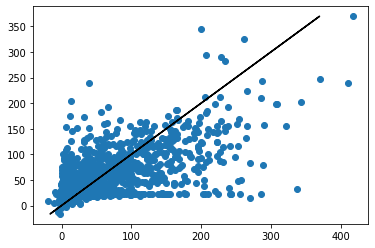

MAE: 31.4
RMSE: 46.8
R^2: 0.46


,fanPts-1,yards_gained-1_seasonTotal,yards_gained-1_avgPerGame,rush_attempt-1_seasonTotal,rec_yards-2_seasonTotal,rush_yards-1_seasonTotal,qb_dropback-2_avgPerGame,yards_gained-3_seasonTotal,yards_gained-2_seasonTotal,qb_dropback-1_avgPerGame,no_huddle-1_seasonTotal,incomplete_pass-1_seasonTotal,qb_dropback-3_avgPerGame,no_huddle-1_avgPerGame,tackled_for_loss-1_avgPerGame,rush_attempt-3_avgPerGame,incomplete_pass-2_seasonTotal,fumble-2_avgPerGame,rush_attempt-1_avgPerGame,pass_touchdown-1_avgPerGame,yards_after_catch-2_seasonTotal,fumble-1_avgPerGame,fumble-3_avgPerGame,air_yards-1_seasonTotal,shotgun-3_avgPerGame,qb_hit-2_seasonTotal,rush_yards-3_seasonTotal,yards_after_catch-1_avgPerGame,air_yards-2_seasonTotal,qb_hit-1_avgPerGame,no_huddle-2_seasonTotal,no_huddle-2_avgPerGame,pass_touchdown-3_avgPerGame,shotgun-2_avgPerGame,yards_gained-2_avgPerGame,pass_touchdown-1_seasonTotal,touchdown-1_avgPerGame,rush_touchdown-2_seasonTotal,shotgun-1_avgPerGame,touchdown-3_avgPerGame,air_yards-3_seasonTotal,interception-1_seasonTotal,fumble-3_seasonTotal,rush_attempt-2_avgPerGame,pass_touchdown-3_seasonTotal,fumble-1_seasonTotal,tackled_for_loss-2_seasonTotal,air_yards-3_avgPerGame,pass_touchdown-2_seasonTotal,fumble-2_seasonTotal,...,shotgun-1_seasonTotal,pass_attempt-2_seasonTotal,tackled_for_loss-1_seasonTotal,touchdown-1_seasonTotal,yards_after_catch-1_seasonTotal,rec_yards-1_seasonTotal,complete_pass-3_seasonTotal,fanPts-2,rush_yards-3_avgPerGame,incomplete_pass-3_seasonTotal,incomplete_pass-2_avgPerGame,pass_attempt-2_avgPerGame,qb_hit-2_avgPerGame,rush_touchdown-2_avgPerGame,tackled_for_loss-2_avgPerGame,touchdown-2_avgPerGame,yards_after_catch-2_avgPerGame,rec_yards-2_avgPerGame,rush_yards-2_avgPerGame,complete_pass-3_avgPerGame,incomplete_pass-3_avgPerGame,interception-3_avgPerGame,no_huddle-3_avgPerGame,pass_attempt-3_avgPerGame,qb_hit-3_avgPerGame,rush_touchdown-3_avgPerGame,tackled_for_loss-3_avgPerGame,yards_after_catch-3_avgPerGame,interception-2_avgPerGame,complete_pass-2_avgPerGame,interception-3_seasonTotal,rush_yards-1_avgPerGame,no_huddle-3_seasonTotal,pass_attempt-3_seasonTotal,qb_dropback-3_seasonTotal,qb_hit-3_seasonTotal,rush_attempt-3_seasonTotal,rush_touchdown-3_seasonTotal,shotgun-3_seasonTotal,tackled_for_loss-3_seasonTotal,touchdown-3_seasonTotal,yards_after_catch-3_seasonTotal,rec_yards-3_avgPerGame,complete_pass-1_avgPerGame,interception-1_avgPerGame,pass_attempt-1_avgPerGame,rush_touchdown-1_avgPerGame,air_yards-1_avgPerGame,rec_yards-1_avgPerGame,rec_yards-3_seasonTotal
1,17.062,14.600,8.758,-8.135,7.120,7.098,-5.306,4.622,4.410,-4.239,-3.718,3.620,-3.333,3.288,3.034,-2.817,-2.394,-1.860,-1.655,-1.515,1.504,-1.470,-1.462,1.453,-1.347,-1.272,1.272,-1.246,1.233,-1.177,-1.154,1.087,0.990,0.915,0.869,0.847,-0.790,0.738,0.736,-0.732,-0.680,-0.614,0.506,-0.405,0.386,-0.372,0.372,-0.336,0.315,-0.274,...,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000


In [13]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, standardized

Alpha: 0.19586058214381202
l1 ratio: 0.75


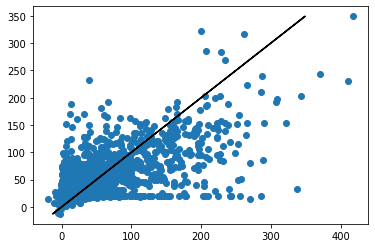

MAE: 31.4
RMSE: 46.9
R^2: 0.46


,yards_gained-1_seasonTotal,fanPts-1,rec_yards-1_seasonTotal,rush_yards-1_seasonTotal,yards_gained-1_avgPerGame,rec_yards-2_seasonTotal,yards_gained-2_seasonTotal,rush_yards-1_avgPerGame,incomplete_pass-1_seasonTotal,qb_dropback-2_avgPerGame,qb_dropback-3_avgPerGame,fanPts-2,touchdown-1_seasonTotal,pass_touchdown-1_seasonTotal,yards_gained-3_seasonTotal,rec_yards-1_avgPerGame,fumble-2_avgPerGame,rush_attempt-3_avgPerGame,tackled_for_loss-1_avgPerGame,fumble-1_avgPerGame,air_yards-1_seasonTotal,fumble-3_avgPerGame,incomplete_pass-2_avgPerGame,no_huddle-1_seasonTotal,pass_attempt-1_seasonTotal,qb_dropback-1_avgPerGame,qb_hit-1_avgPerGame,yards_after_catch-2_seasonTotal,rush_touchdown-1_seasonTotal,pass_touchdown-1_avgPerGame,shotgun-3_avgPerGame,rush_yards-3_seasonTotal,no_huddle-1_avgPerGame,air_yards-2_seasonTotal,qb_hit-2_seasonTotal,complete_pass-1_seasonTotal,pass_touchdown-3_seasonTotal,touchdown-1_avgPerGame,rec_yards-3_seasonTotal,fumble-1_seasonTotal,yards_after_catch-1_avgPerGame,yards_gained-2_avgPerGame,fanPts-3,pass_touchdown-2_seasonTotal,air_yards-3_avgPerGame,tackled_for_loss-3_seasonTotal,tackled_for_loss-2_seasonTotal,rush_touchdown-3_avgPerGame,rush_attempt-2_avgPerGame,fumble-2_seasonTotal,...,interception-1_seasonTotal,qb_dropback-2_seasonTotal,tackled_for_loss-3_avgPerGame,qb_dropback-1_seasonTotal,pass_attempt-2_seasonTotal,qb_hit-1_seasonTotal,no_huddle-2_seasonTotal,rush_attempt-1_seasonTotal,incomplete_pass-2_seasonTotal,tackled_for_loss-1_seasonTotal,complete_pass-2_seasonTotal,incomplete_pass-3_avgPerGame,interception-3_avgPerGame,no_huddle-3_avgPerGame,pass_attempt-3_avgPerGame,yards_after_catch-1_seasonTotal,complete_pass-2_avgPerGame,yards_after_catch-2_avgPerGame,shotgun-2_seasonTotal,touchdown-2_seasonTotal,air_yards-1_avgPerGame,pass_attempt-2_avgPerGame,rush_touchdown-1_avgPerGame,rush_attempt-1_avgPerGame,pass_touchdown-2_avgPerGame,pass_attempt-1_avgPerGame,rush_touchdown-2_avgPerGame,incomplete_pass-1_avgPerGame,complete_pass-1_avgPerGame,tackled_for_loss-2_avgPerGame,rec_yards-3_avgPerGame,touchdown-2_avgPerGame,yards_after_catch-3_seasonTotal,air_yards-3_seasonTotal,touchdown-3_seasonTotal,shotgun-3_seasonTotal,rush_touchdown-3_seasonTotal,rush_attempt-3_seasonTotal,qb_hit-3_seasonTotal,qb_dropback-3_seasonTotal,air_yards-2_avgPerGame,pass_attempt-3_seasonTotal,no_huddle-3_seasonTotal,interception-3_seasonTotal,incomplete_pass-3_seasonTotal,complete_pass-3_seasonTotal,rush_yards-2_seasonTotal,interception-2_avgPerGame,rush_yards-2_avgPerGame,rush_yards-3_avgPerGame
1,8.459,7.128,5.682,5.274,4.605,3.360,3.204,2.985,2.703,-2.539,-2.371,2.314,2.235,1.979,1.979,1.973,-1.850,-1.746,1.703,-1.666,1.549,-1.384,-1.342,-1.286,1.268,-1.268,-1.231,1.150,1.143,-1.125,-1.093,1.081,0.981,0.813,-0.776,0.770,0.684,-0.634,0.633,-0.559,-0.545,0.520,0.498,0.493,-0.449,0.434,0.390,-0.359,-0.331,-0.309,...,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000


In [14]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized, hand-selected features

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    8.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.0s finished
C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6957235.9448466, tolerance: 3037.9150681688084
  positive)


Best parameters set found on development set:
{'alpha': 0.001, 'l1_ratio': 0.75, 'normalize': False}


C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6957235.9448466, tolerance: 3037.9150681688084
  positive)


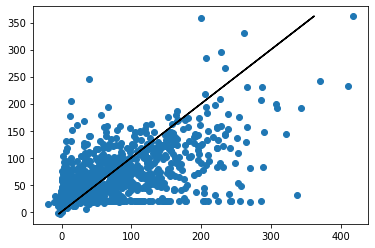

MAE: 31.5
RMSE: 47.2
R^2: 0.45


,fanPts-1,fanPts-2,yards_gained-2_seasonTotal,fanPts-3,touchdown-2_seasonTotal,touchdown-1_seasonTotal,yards_gained-3_seasonTotal,rush_attempt-1_seasonTotal,complete_pass-1_seasonTotal,touchdown-3_seasonTotal,rush_attempt-1_avgPerGame,rush_attempt-3_avgPerGame,complete_pass-2_avgPerGame,complete_pass-2_seasonTotal,complete_pass-3_avgPerGame,rush_attempt-2_avgPerGame,yards_gained-2_avgPerGame,touchdown-1_avgPerGame,complete_pass-1_avgPerGame,complete_pass-3_seasonTotal,rush_attempt-3_seasonTotal,rush_attempt-2_seasonTotal,yards_gained-1_avgPerGame,yards_gained-3_avgPerGame,yards_gained-1_seasonTotal,touchdown-3_avgPerGame,touchdown-2_avgPerGame
1,58.223,47.616,-27.914,24.890,-14.735,-11.896,-10.173,-9.001,-8.858,-8.672,6.136,-5.501,-5.482,4.092,-4.018,-3.790,3.395,-3.193,2.790,-2.568,2.460,1.652,0.896,0.597,-0.512,-0.484,-0.222


In [15]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False],
    'l1_ratio':[.25,.5,.75]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, standardized, hand-selected features

Alpha: 0.05578179631582934
l1 ratio: 0.75


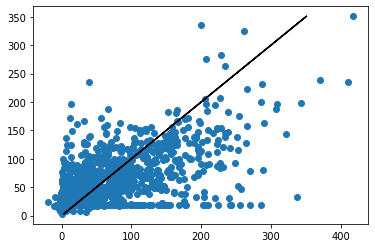

MAE: 31.5
RMSE: 47.1
R^2: 0.45


,fanPts-1,yards_gained-1_seasonTotal,yards_gained-1_avgPerGame,fanPts-2,fanPts-3,yards_gained-2_seasonTotal,complete_pass-3_avgPerGame,rush_attempt-3_avgPerGame,yards_gained-3_seasonTotal,touchdown-1_avgPerGame,rush_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-1_seasonTotal,complete_pass-3_seasonTotal,rush_attempt-1_seasonTotal,complete_pass-1_avgPerGame,touchdown-3_avgPerGame,touchdown-2_avgPerGame,rush_attempt-3_seasonTotal,yards_gained-2_avgPerGame,touchdown-3_seasonTotal,rush_attempt-1_avgPerGame,touchdown-2_seasonTotal,complete_pass-2_seasonTotal,complete_pass-1_seasonTotal,rush_attempt-2_seasonTotal,yards_gained-3_avgPerGame
1,17.082,14.231,8.062,6.943,3.975,3.714,-3.614,-3.532,2.915,-2.733,-2.575,-2.392,1.844,-1.318,-1.260,-1.244,-1.155,-0.906,0.865,0.820,-0.790,0.655,-0.478,0.399,0.340,-0.210,0.000


In [16]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized, hand-selected features, force positive coefficients

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    7.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.5s finished


Best parameters set found on development set:
{'alpha': 0.01, 'l1_ratio': 0.25, 'normalize': False, 'positive': True}


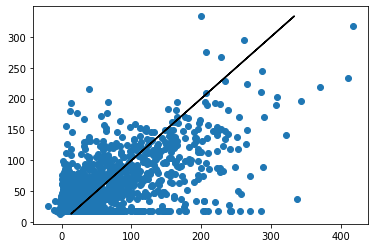

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,yards_gained-1_seasonTotal,fanPts-1,fanPts-2,yards_gained-1_avgPerGame,yards_gained-2_seasonTotal,complete_pass-2_seasonTotal,complete_pass-1_seasonTotal,rush_attempt-3_seasonTotal,rush_attempt-1_seasonTotal,touchdown-1_seasonTotal,rush_attempt-2_seasonTotal,touchdown-2_seasonTotal,fanPts-3,complete_pass-3_seasonTotal,yards_gained-3_avgPerGame,touchdown-3_avgPerGame,yards_gained-3_seasonTotal,complete_pass-1_avgPerGame,rush_attempt-1_avgPerGame,touchdown-1_avgPerGame,complete_pass-2_avgPerGame,rush_attempt-2_avgPerGame,touchdown-2_avgPerGame,yards_gained-2_avgPerGame,complete_pass-3_avgPerGame,rush_attempt-3_avgPerGame,touchdown-3_seasonTotal
1,17.817,16.262,4.502,2.983,1.984,0.544,0.170,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [17]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'alpha':[10**x for x in range(-4,6)],
    'normalize':[True,False],
    'l1_ratio':[.25,.5,.75],
    'positive':[True]
}

grid = GridSearchCV(
    linear_model.ElasticNet(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, standardized, hand-selected features, force positive coefficients

Alpha: 0.05578179631582934
l1 ratio: 0.75


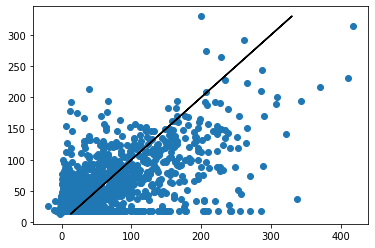

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,yards_gained-1_seasonTotal,fanPts-1,fanPts-2,yards_gained-1_avgPerGame,yards_gained-2_seasonTotal,complete_pass-1_seasonTotal,complete_pass-2_seasonTotal,rush_attempt-3_seasonTotal,rush_attempt-1_seasonTotal,touchdown-1_seasonTotal,rush_attempt-2_seasonTotal,touchdown-2_seasonTotal,fanPts-3,complete_pass-3_seasonTotal,yards_gained-3_avgPerGame,touchdown-3_avgPerGame,yards_gained-3_seasonTotal,complete_pass-1_avgPerGame,rush_attempt-1_avgPerGame,touchdown-1_avgPerGame,complete_pass-2_avgPerGame,rush_attempt-2_avgPerGame,touchdown-2_avgPerGame,yards_gained-2_avgPerGame,complete_pass-3_avgPerGame,rush_attempt-3_avgPerGame,touchdown-3_seasonTotal
1,16.869,16.203,4.219,3.458,2.506,0.662,0.279,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [18]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], positive=[True], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

### Bayesian Ridge Regression

#### Base model

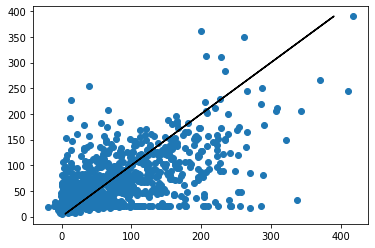

MAE: 31.5
RMSE: 47.2
R^2: 0.45


,qb_dropback-2_seasonTotal,qb_dropback-1_seasonTotal,rush_attempt-1_seasonTotal,fanPts-1,qb_dropback-3_seasonTotal,incomplete_pass-1_seasonTotal,yards_gained-3_avgPerGame,pass_attempt-1_seasonTotal,yards_gained-1_avgPerGame,rush_attempt-3_seasonTotal,rush_yards-3_avgPerGame,rush_yards-1_avgPerGame,fumble-1_seasonTotal,tackled_for_loss-1_seasonTotal,air_yards-1_avgPerGame,fumble-2_seasonTotal,incomplete_pass-2_seasonTotal,yards_gained-2_avgPerGame,rec_yards-2_avgPerGame,qb_hit-2_seasonTotal,complete_pass-2_seasonTotal,no_huddle-1_seasonTotal,incomplete_pass-3_seasonTotal,yards_after_catch-3_avgPerGame,fanPts-2,rush_attempt-3_avgPerGame,shotgun-3_seasonTotal,yards_gained-1_seasonTotal,tackled_for_loss-2_seasonTotal,complete_pass-3_seasonTotal,qb_hit-1_seasonTotal,rush_yards-1_seasonTotal,qb_dropback-2_avgPerGame,fumble-3_seasonTotal,tackled_for_loss-3_seasonTotal,yards_after_catch-2_avgPerGame,rush_attempt-2_avgPerGame,rec_yards-3_avgPerGame,yards_after_catch-1_avgPerGame,qb_dropback-3_avgPerGame,qb_dropback-1_avgPerGame,pass_touchdown-3_seasonTotal,pass_attempt-3_seasonTotal,yards_gained-3_seasonTotal,rec_yards-2_seasonTotal,shotgun-1_avgPerGame,rec_yards-1_avgPerGame,interception-1_seasonTotal,rush_attempt-2_seasonTotal,air_yards-3_avgPerGame,...,pass_attempt-1_avgPerGame,interception-2_seasonTotal,fumble-1_avgPerGame,fanPts-3,shotgun-2_avgPerGame,yards_after_catch-2_seasonTotal,complete_pass-1_seasonTotal,yards_after_catch-3_seasonTotal,complete_pass-3_avgPerGame,rush_attempt-1_avgPerGame,rec_yards-3_seasonTotal,incomplete_pass-2_avgPerGame,air_yards-1_seasonTotal,fumble-3_avgPerGame,rush_touchdown-1_seasonTotal,no_huddle-2_avgPerGame,incomplete_pass-1_avgPerGame,complete_pass-1_avgPerGame,interception-3_seasonTotal,air_yards-3_seasonTotal,rush_touchdown-2_seasonTotal,rush_yards-2_seasonTotal,qb_hit-1_avgPerGame,no_huddle-2_seasonTotal,qb_hit-3_seasonTotal,rec_yards-1_seasonTotal,complete_pass-2_avgPerGame,touchdown-1_avgPerGame,pass_touchdown-2_seasonTotal,pass_touchdown-1_avgPerGame,pass_touchdown-1_seasonTotal,tackled_for_loss-2_avgPerGame,qb_hit-2_avgPerGame,touchdown-2_avgPerGame,touchdown-3_avgPerGame,rush_touchdown-3_avgPerGame,rush_yards-2_avgPerGame,incomplete_pass-3_avgPerGame,air_yards-2_seasonTotal,no_huddle-3_avgPerGame,pass_touchdown-3_avgPerGame,interception-1_avgPerGame,tackled_for_loss-3_avgPerGame,pass_touchdown-2_avgPerGame,qb_hit-3_avgPerGame,touchdown-1_seasonTotal,rush_touchdown-2_avgPerGame,interception-2_avgPerGame,rush_touchdown-1_avgPerGame,interception-3_avgPerGame
1,-0.250,-0.245,-0.217,0.188,-0.181,0.156,-0.136,0.133,0.121,-0.112,-0.098,0.096,-0.093,0.092,-0.089,-0.087,-0.081,-0.077,-0.075,-0.065,0.061,-0.060,0.059,-0.055,0.054,-0.052,-0.052,0.050,0.049,-0.046,-0.046,0.045,-0.042,-0.041,0.040,-0.040,-0.038,-0.038,-0.036,-0.035,-0.028,0.028,0.027,0.027,0.025,0.025,0.025,-0.022,-0.022,-0.022,...,0.012,0.012,-0.012,-0.012,0.012,0.011,0.011,0.011,-0.011,0.009,0.009,-0.009,0.009,-0.008,0.008,0.008,0.007,0.007,0.007,-0.006,0.006,-0.006,-0.006,-0.005,0.005,0.005,-0.005,-0.004,-0.004,-0.004,0.004,0.003,-0.003,-0.003,-0.003,-0.003,-0.003,-0.003,0.003,0.002,0.002,-0.001,-0.001,-0.001,-0.001,-0.001,-0.000,-0.000,0.000,-0.000


In [19]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.BayesianRidge()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Fitting 3 folds for each of 1250 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapse

Best parameters set found on development set:
{'alpha_1': 0.01, 'alpha_2': 100, 'lambda_1': 10, 'lambda_2': 0.01, 'normalize': True}


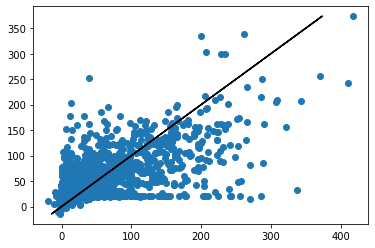

MAE: 31.4
RMSE: 46.9
R^2: 0.46


,fumble-3_avgPerGame,fumble-2_avgPerGame,fumble-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_touchdown-3_avgPerGame,qb_hit-1_avgPerGame,touchdown-3_avgPerGame,tackled_for_loss-1_avgPerGame,touchdown-1_avgPerGame,touchdown-2_avgPerGame,no_huddle-1_avgPerGame,rush_touchdown-2_avgPerGame,pass_touchdown-2_avgPerGame,no_huddle-2_avgPerGame,interception-2_avgPerGame,rush_touchdown-1_avgPerGame,rush_touchdown-3_avgPerGame,tackled_for_loss-3_avgPerGame,qb_dropback-1_avgPerGame,qb_dropback-2_avgPerGame,tackled_for_loss-2_avgPerGame,incomplete_pass-2_avgPerGame,interception-3_avgPerGame,pass_touchdown-1_seasonTotal,qb_dropback-3_avgPerGame,no_huddle-3_avgPerGame,rush_touchdown-1_seasonTotal,rush_attempt-3_avgPerGame,fumble-3_seasonTotal,shotgun-2_avgPerGame,shotgun-3_avgPerGame,qb_hit-3_avgPerGame,rush_attempt-2_avgPerGame,touchdown-1_seasonTotal,pass_touchdown-3_seasonTotal,complete_pass-3_avgPerGame,rush_attempt-1_avgPerGame,qb_hit-2_seasonTotal,incomplete_pass-1_avgPerGame,fumble-1_seasonTotal,rush_touchdown-2_seasonTotal,touchdown-3_seasonTotal,interception-2_seasonTotal,shotgun-1_avgPerGame,pass_touchdown-2_seasonTotal,fumble-2_seasonTotal,no_huddle-1_seasonTotal,interception-1_seasonTotal,pass_attempt-2_avgPerGame,rush_touchdown-3_seasonTotal,...,yards_after_catch-3_avgPerGame,tackled_for_loss-1_seasonTotal,incomplete_pass-2_seasonTotal,tackled_for_loss-2_seasonTotal,fanPts-1,pass_attempt-1_avgPerGame,complete_pass-2_seasonTotal,rec_yards-2_avgPerGame,rec_yards-3_avgPerGame,rush_yards-2_avgPerGame,incomplete_pass-3_seasonTotal,yards_gained-2_avgPerGame,complete_pass-1_seasonTotal,yards_gained-3_avgPerGame,air_yards-1_avgPerGame,no_huddle-3_seasonTotal,pass_attempt-1_seasonTotal,rush_yards-3_avgPerGame,air_yards-2_avgPerGame,air_yards-3_avgPerGame,qb_dropback-3_seasonTotal,fanPts-2,complete_pass-3_seasonTotal,qb_dropback-2_seasonTotal,rush_yards-1_seasonTotal,incomplete_pass-3_avgPerGame,yards_after_catch-2_seasonTotal,yards_gained-1_seasonTotal,rush_attempt-1_seasonTotal,fanPts-3,shotgun-2_seasonTotal,rec_yards-1_seasonTotal,qb_dropback-1_seasonTotal,yards_after_catch-3_seasonTotal,rec_yards-2_seasonTotal,shotgun-3_seasonTotal,rush_attempt-3_seasonTotal,yards_after_catch-1_seasonTotal,rush_yards-3_seasonTotal,pass_attempt-2_seasonTotal,yards_gained-2_seasonTotal,air_yards-1_seasonTotal,yards_gained-3_seasonTotal,rec_yards-3_seasonTotal,air_yards-2_seasonTotal,air_yards-3_seasonTotal,shotgun-1_seasonTotal,rush_yards-2_seasonTotal,pass_attempt-3_seasonTotal,rush_attempt-2_seasonTotal
1,-16.121,-13.974,-12.300,-10.800,9.979,-8.521,-7.827,6.354,-5.821,-5.515,5.044,4.625,4.620,3.443,-2.678,-2.137,1.716,-1.701,-1.598,-1.487,1.425,-1.265,1.147,1.135,-1.112,0.919,0.914,-0.867,0.861,0.856,-0.851,-0.740,-0.718,0.717,0.690,-0.679,-0.675,-0.607,0.590,-0.553,0.532,-0.529,0.521,0.503,0.484,-0.432,-0.403,-0.388,-0.371,0.366,...,-0.140,-0.135,-0.115,0.109,0.108,0.107,0.068,0.066,0.060,0.060,0.059,0.059,0.047,0.047,-0.046,-0.045,0.043,0.042,0.039,-0.038,-0.037,0.032,-0.028,-0.026,0.026,0.023,0.022,0.018,-0.018,0.017,-0.016,0.016,-0.016,0.013,0.012,-0.012,-0.011,0.009,0.007,0.007,0.007,0.006,0.005,0.005,0.004,-0.004,-0.003,0.001,-0.000,-0.000


In [20]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'alpha_1':[10**x for x in range(-2,3)],
    'alpha_2':[10**x for x in range(-2,3)],
    'lambda_1':[10**x for x in range(-2,3)],
    'lambda_2':[10**x for x in range(-2,3)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 3
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized

Fitting 3 folds for each of 1250 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapse

Best parameters set found on development set:
{'alpha_1': 0.01, 'alpha_2': 100, 'lambda_1': 10, 'lambda_2': 0.01, 'normalize': False}


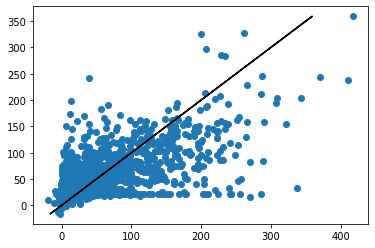

MAE: 31.4
RMSE: 46.9
R^2: 0.46


,yards_gained-1_seasonTotal,rush_yards-1_seasonTotal,fanPts-1,yards_gained-1_avgPerGame,rec_yards-1_seasonTotal,rush_yards-1_avgPerGame,qb_dropback-1_avgPerGame,rec_yards-2_seasonTotal,qb_dropback-2_avgPerGame,rec_yards-1_avgPerGame,incomplete_pass-1_seasonTotal,no_huddle-1_seasonTotal,yards_gained-2_seasonTotal,rush_attempt-3_avgPerGame,tackled_for_loss-1_avgPerGame,no_huddle-1_avgPerGame,pass_touchdown-1_seasonTotal,rush_attempt-1_avgPerGame,rush_attempt-2_avgPerGame,qb_dropback-3_avgPerGame,yards_after_catch-2_seasonTotal,touchdown-1_seasonTotal,air_yards-1_seasonTotal,yards_after_catch-1_avgPerGame,yards_gained-3_seasonTotal,rush_touchdown-1_seasonTotal,fanPts-2,no_huddle-2_seasonTotal,pass_attempt-1_seasonTotal,pass_touchdown-1_avgPerGame,qb_hit-1_avgPerGame,incomplete_pass-2_seasonTotal,rush_yards-3_seasonTotal,fumble-3_avgPerGame,qb_hit-2_seasonTotal,complete_pass-2_seasonTotal,no_huddle-2_avgPerGame,fumble-2_avgPerGame,touchdown-3_seasonTotal,fumble-1_avgPerGame,yards_gained-2_avgPerGame,touchdown-3_avgPerGame,shotgun-2_avgPerGame,pass_touchdown-3_seasonTotal,rec_yards-3_seasonTotal,air_yards-2_seasonTotal,qb_dropback-3_seasonTotal,pass_touchdown-3_avgPerGame,shotgun-3_avgPerGame,yards_after_catch-2_avgPerGame,...,complete_pass-3_avgPerGame,shotgun-1_avgPerGame,rush_yards-2_avgPerGame,fanPts-3,yards_after_catch-3_avgPerGame,pass_attempt-2_avgPerGame,air_yards-2_avgPerGame,tackled_for_loss-1_seasonTotal,touchdown-2_seasonTotal,incomplete_pass-3_seasonTotal,interception-2_seasonTotal,air_yards-3_avgPerGame,fumble-1_seasonTotal,pass_touchdown-2_avgPerGame,rush_touchdown-3_seasonTotal,complete_pass-3_seasonTotal,tackled_for_loss-2_seasonTotal,qb_dropback-1_seasonTotal,rush_touchdown-2_avgPerGame,qb_hit-1_seasonTotal,rush_yards-3_avgPerGame,interception-1_seasonTotal,tackled_for_loss-3_avgPerGame,pass_attempt-3_avgPerGame,incomplete_pass-1_avgPerGame,tackled_for_loss-2_avgPerGame,rush_attempt-3_seasonTotal,fumble-2_seasonTotal,complete_pass-2_avgPerGame,qb_hit-3_seasonTotal,shotgun-2_seasonTotal,no_huddle-3_avgPerGame,complete_pass-1_avgPerGame,rush_touchdown-1_avgPerGame,shotgun-3_seasonTotal,no_huddle-3_seasonTotal,interception-2_avgPerGame,pass_attempt-2_seasonTotal,pass_attempt-1_avgPerGame,rush_yards-2_seasonTotal,interception-3_seasonTotal,rush_touchdown-3_avgPerGame,qb_hit-3_avgPerGame,interception-3_avgPerGame,shotgun-1_seasonTotal,qb_hit-2_avgPerGame,interception-1_avgPerGame,incomplete_pass-3_avgPerGame,rush_attempt-2_seasonTotal,pass_attempt-3_seasonTotal
1,8.116,6.936,6.672,5.571,5.290,4.553,-4.008,3.926,-3.673,3.496,3.244,-3.239,3.068,-2.962,2.843,2.799,2.788,-2.767,-2.708,-2.608,2.510,2.435,2.289,-2.155,2.070,2.007,1.953,-1.850,1.801,-1.768,-1.760,-1.741,1.734,-1.727,-1.724,1.722,1.710,-1.647,-1.611,-1.561,1.560,-1.552,1.510,1.497,1.483,1.477,-1.442,1.420,-1.377,-1.362,...,-0.996,0.978,0.972,0.940,-0.935,-0.928,0.875,-0.867,-0.853,0.844,0.799,-0.763,-0.734,0.723,0.689,-0.660,0.653,-0.652,0.639,0.635,0.629,-0.626,-0.607,-0.595,0.577,0.573,-0.565,-0.549,-0.538,0.519,-0.447,0.427,0.403,-0.329,-0.308,-0.308,-0.295,0.291,0.274,0.259,0.241,0.218,-0.124,0.113,-0.084,0.044,0.040,0.020,-0.011,-0.010


In [21]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

params = {
    'alpha_1':[10**x for x in range(-2,3)],
    'alpha_2':[10**x for x in range(-2,3)],
    'lambda_1':[10**x for x in range(-2,3)],
    'lambda_2':[10**x for x in range(-2,3)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 3
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, standardized, hand-selected features

Fitting 5 folds for each of 1250 candidates, totalling 6250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1424 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 2664 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 3032 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 4328 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 4824 tasks      | 

Best parameters set found on development set:
{'alpha_1': 100, 'alpha_2': 0.01, 'lambda_1': 0.01, 'lambda_2': 100, 'normalize': False}


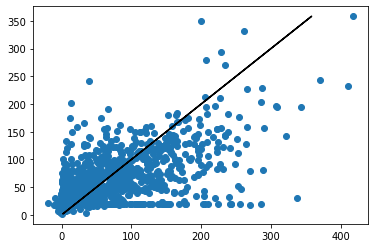

MAE: 31.5
RMSE: 47.1
R^2: 0.45


,fanPts-1,fanPts-2,fanPts-3,yards_gained-1_seasonTotal,yards_gained-2_seasonTotal,rush_attempt-1_seasonTotal,touchdown-2_seasonTotal,rush_attempt-3_avgPerGame,complete_pass-1_seasonTotal,touchdown-3_seasonTotal,yards_gained-1_avgPerGame,complete_pass-2_avgPerGame,rush_attempt-1_avgPerGame,complete_pass-3_avgPerGame,rush_attempt-2_avgPerGame,touchdown-1_seasonTotal,touchdown-1_avgPerGame,complete_pass-3_seasonTotal,complete_pass-2_seasonTotal,yards_gained-2_avgPerGame,rush_attempt-3_seasonTotal,yards_gained-3_seasonTotal,touchdown-3_avgPerGame,complete_pass-1_avgPerGame,rush_attempt-2_seasonTotal,yards_gained-3_avgPerGame,touchdown-2_avgPerGame
1,33.207,20.796,13.257,11.406,-6.925,-6.460,-5.990,-5.284,-5.021,-4.880,4.545,-4.399,4.002,-3.710,-3.438,-3.344,-3.306,-2.750,2.377,2.330,2.121,-1.784,-0.602,0.533,0.471,0.390,-0.356


In [22]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'alpha_1':[10**x for x in range(-2,3)],
    'alpha_2':[10**x for x in range(-2,3)],
    'lambda_1':[10**x for x in range(-2,3)],
    'lambda_2':[10**x for x in range(-2,3)],
    'normalize':[True,False]
}

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# cvGrid(params)

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features, force positive coefficients

In [23]:
# X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

# params = {
#     'alpha_1':[10**x for x in range(-4,10)],
#     'alpha_2':[10**x for x in range(-4,10)],
#     'lambda_1':[10**x for x in range(-4,10)],
#     'lambda_2':[10**x for x in range(-4,10)],
#     'normalize':[True,False],
#     'positive':[True]
# }

# grid = GridSearchCV(
#     linear_model.BayesianRidge(),
#     params,
#     n_jobs = -1,
#     verbose = 7,
#     cv = 5
# )

# grid.fit(X_train,y_train)

# print("Best parameters set found on development set:")
# print(grid.best_params_)
     
# # cvGrid(params)

# clf = linear_model.BayesianRidge(**grid.best_params_)
# clf.fit(X_train,y_train)
# y_pred = clf.predict(X_dev)

# printStats(y_dev, y_pred)

# coefs = pd.DataFrame([X_train.columns,clf.coef_]).transpose()
# coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
# coefs